# ocean_driven_SST:

SST anomalies caused by anomalous ocean circulation in the eastern equatorial Pacific.

Computes the amount of cooling (warming) by anomalous ocean circulation needed to generate surface temperature anomalies (SSTA) of -1 (1) °C during La Nina (El Nino) events in the eastern equatorial Pacific (horizontal Niño3 average)

#### Reference observations:
TropFlux 1979-2018 (main)

NHF: OAFlux-ISCCP 1984-2009, DEEP-C 1985-2016, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023
SST: ERSSTv5 1854-2023, HadISST 1870-2023, COBE2 1850-2023, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023


In [1]:
from esmvalcore.dataset import Dataset
from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #NCEP-DOE-R2 tos

In [2]:
# varaibles ts, hfds
model_ts_datasets = { 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}
model_ts_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

model_ts = {name: dataset.load() for name, dataset in model_ts_datasets.items()}

In [3]:
model_hfls_datasets = { 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='hfls',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

model_hfls_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacella', mip='fx')

#rest variables
model_other = {}
for cvar in ['hfss','rlds','rlus','rsds','rsus']:
    
    model_other[cvar] = model_hfls_datasets["ACCESS-ESM1-5"].copy(short_name=cvar)


In [4]:
model_hfls = {name: dataset.load() for name, dataset in model_hfls_datasets.items()}
model_rest = {name: dataset.load() for name, dataset in model_other.items()}

# nhf = -*hfls* -hfss + rlds - rlus + rsds - rsus #if 'd' make positive
model_nhf = - model_hfls['ACCESS-ESM1-5'] - model_rest['hfss'] + model_rest['rlds']- model_rest['rlus']+ model_rest['rsds']- model_rest['rsus']

 hfls: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/hfls/gn/v20191115/hfls_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 hfls: attribute positive not present
loaded from file 
 hfss: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/hfss/gn/v20191115/hfss_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 hfss: attribute positive not present
loaded from file 
 rlds: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/rlds/gn/v20191115/rlds_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 rlds: attribute positive not present
loaded from file 
 rlus: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/rlus/gn/v20191115/rlus_Amon_ACCESS-ESM

In [5]:
obs_tos_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    timerange="19790101/20190101",
    tier=2),
"TROPFLUX":
    Dataset(
    short_name='tos',
    dataset='TROPFLUX',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    timerange="19790101/20190101",
    tier=2)
}
obs_nhf_datasets = { ##
 # "TROPFLUX": ##netflux data to kj13
 #     Dataset(
 #     short_name='hfds',
 #     dataset='TROPFLUX',
 #     mip="Omon",
 #     project='OBS6',
 #     type='reanaly',
 #     timerange="19790101/20190101",
     # tier=2),
 "ERA-Interim": 
     Dataset(
     short_name='hfds',
     dataset='ERA-Interim',
     mip="Omon",
     project='OBS6',
     type='reanaly',
     timerange="19790101/20190101",
     tier=3)
}

In [15]:
obs_nhf = {name: dataset.load() for name, dataset in obs_nhf_datasets.items()}
obs_tos = {name: dataset.load() for name, dataset in obs_tos_datasets.items()}

In [7]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import annual_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats

In [8]:
def sst_enso_n34(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land") #
    cube = extract_region(cube, **nino34_latext_region)
    # #remove time mean
    cube = anomalies(cube, period='monthly') 
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)##rolling window cuts off months?
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube,operator='mean')
    cube = extract_month(cube,12)
    # detrend?
    cube = detrend(cube, dimension="time", method="linear")
    # normalize time series using its temporal standard deviation
    return cube
    
def east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    # cube = convert_units(cube, units="degC")
    cube = extract_region(cube, **nino3_region)
    # cube = detrend(cube, dimension="time", method="linear")
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)##rolling window cuts off months?
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube, operator='mean')
    cube = anomalies(cube, period="full") #remove seasonal cycle
    
    return cube

In [9]:
## dsst_nhf
#nhf : season, aunnual
def trend_month_sst(cube_prep): #e.g., dSST[feb] = SST[feb] - SST [jan]
    a_data = cube_prep.data.data
    a1_data = np.append(np.delete(a_data, 0), 0) #add 0 to end
    trend_data = a1_data - a_data #last month value invalid
    cube_prep.data = trend_data
    cube = extract_season(cube_prep,'JASOND')
    cube = annual_statistics(cube, 'sum')[:-1]
    return cube

def dSSTnhf(nhf_east, sst_east):
    dtime = 60 * 60 * 24 * 30.42 #s month-1
    Cp = 4000 #J kg-1 degC-1
    rho = 1024 #kg m-3
    H = 50 #m
    print(nhf_east.shape, sst_east.shape)
    datetime_match(nhf_east, sst_east)
    dsstnhf = dtime * nhf_east[:-1] / (sst_east * Cp * rho * H)
    return dsstnhf

def datetime_match(cube, cube_2): #sync 2 cubes time -obs are different
    t_coord = cube.coord('time')
    time_standard = t_coord.units.num2date(t_coord.points[0])
    years1 = cube.coord('year').points
    new_time_1 = [time_standard.replace(year=y) for y in years1]
    cube.coord('time').points = t_coord.units.date2num(new_time_1).astype('float64')

    years2 = cube_2.coord('year').points
    new_time_2 = [time_standard.replace(year=y) for y in years2]
    cube_2.coord('time').points = t_coord.units.date2num(new_time_2).astype('float64')
    
    t_coord.bounds = None 
    cube_2.coord('time').bounds = None

In [33]:
model_nhf_prep = {'ACCESS-ESM1-5': east(model_nhf)}
cube = model_nhf_prep['ACCESS-ESM1-5']
east_cube = extract_season(cube,'JASOND')
print(cube.shape, east_cube.shape)
nhf_east = annual_statistics(east_cube, 'sum')

obs_nhf_prep = {name: east(dataset) for name, dataset in obs_nhf.items()}
cube = obs_nhf_prep['ERA-Interim']
east_cube = extract_season(cube,'JASOND')
print(cube.shape, east_cube.shape)
obs_nhf_east = annual_statistics(east_cube, 'sum')

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iri

(424,) (212,)
(472,) (236,)


In [11]:
model_ts_prep = {name: east(dataset) for name, dataset in model_ts.items()}
obs_ts_prep = {name: east(dataset) for name, dataset in obs_tos.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iri

In [ ]:
obs_sst = trend_month_sst(obs_ts_prep['TROPFLUX'])
mod_sst = trend_month_sst(model_ts_prep['ACCESS-ESM1-5'])

# qplt.plot(obs_sst)
# qplt.plot(mod_sst, label='model')

model = dSSTnhf(nhf_east, mod_sst)
obs = dSSTnhf(obs_nhf_east, obs_sst) #different time points

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iri

(36,) (35,)
(40,) (39,)


In [66]:
model_ts_enso = {name: sst_enso_n34(dataset) for name, dataset in model_ts.items()}
obs_tos_enso = {name: sst_enso_n34(dataset) for name, dataset in obs_tos.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetad

In [86]:
# detect nino and nina
from esmvalcore.preprocessor import mask_above_threshold, mask_below_threshold
def enso_events(cube):
    a_events = mask_to_years(mask_above_threshold(cube.copy(), -0.75))
    o_events = mask_to_years(mask_below_threshold(cube.copy(), 0.75))
    return {'nina':a_events, 'nino':o_events}

def mask_to_years(events):
    maskedTime = np.ma.masked_array(events.coord('time').points, mask=events.data.mask)
    return [events.coord('time').units.num2date(time).year for time in maskedTime.compressed()]

def dSSTnhf_ninonina(events_dict, dsstnhf):
    datapoints = []
    for enso, events in events_dict.items():
        year_enso = iris.Constraint(time=lambda cell: cell.point.year in events)
        cube = dsstnhf.extract(year_enso)
        ## regroup and average
        if enso == 'nina':
            cube.data = -1 * cube.data
        datapoints.append(cube.data)
        print(enso, [d for d in cube.data.data])
    return datapoints

In [87]:
events = enso_events(model_ts_enso['ACCESS-ESM1-5'])
print(events)
mod_data = dSSTnhf_ninonina(events, model)
events = enso_events(obs_tos_enso['TROPFLUX'])
print(events)
obs_data = dSSTnhf_ninonina(events, obs)

{'nina': [1984, 1985, 1990, 1993, 1999, 2006, 2011], 'nino': [1979, 1983, 1995, 1998, 2001, 2013]}
nina [-0.3516687677094778, 1.245785188139738, -2.398401142258817, -0.047522637917054564, 0.36063981858132477, -0.48849478326689205, -0.6615546209119564]
nino [-1.9818843581938215, -2.4196703039571785, -6.747940279874481, -23.71039519737672, -1.9208833256804743, -3.8460019272753216]
{'nina': [1983, 1984, 1988, 1995, 1998, 1999, 2007, 2010, 2011], 'nino': [1982, 1986, 1987, 1991, 1994, 1997, 2002, 2009, 2015]}
nina [1.0010275568890556, 3.3396852139444126, -7.069601748851709, 4.215879213252012, 2.2616499939913797, 4.877215952036604, 2.0672027612340633, 1.8294105768582392, -0.16513302545945463]
nino [-1.6190782650057343, -0.46019991661649734, 0.4124574765228335, -0.8787403215901326, -0.8277463952316726, -4.803511961128264, -9.397323107056337, -7.455858415519433, -11.540198538021368]


In [92]:
lsall =[]
for mem in mod_data:
    mean = np.mean(mem)
    ls = [d for d in mem]
    lsall += ls
    print(mean, np.mean(lsall))

ave = np.mean(lsall) 
normarray = lsall - ave #normalised, dsst?
np.mean(normarray), normarray, ave
#wiki : dSSToce = dSST - dSSTnhf, spreadsheet 1-averaged data

-0.3344595636204479 -0.3344595636204479
-6.771129232059665 -3.3052301798231634


(-7.344552316751035e-16,
 array([  2.95356141,   4.55101537,   0.90682904,   3.25770754,
          3.66587   ,   2.8167354 ,   2.64367556,   1.32334582,
          0.88555988,  -3.4427101 , -20.40516502,   1.38434685,
         -0.54077175]),
 -3.3052301798231634)

In [93]:
lsall =[]
for mem in obs_data:
    mean = np.mean(mem)
    ls = [d for d in mem]
    lsall += ls
    print(mean, np.mean(lsall))

ave_obs = np.mean(lsall) 
ave_obs

1.3730373882105116 1.3730373882105116
-4.063355493738511 -1.3451590527640003


-1.3451590527640003

# Diagnostic Level 1

Figure 1: sea surface temperature anomalies (SSTA) caused by anomalous ocean circulation in the eastern equatorial Pacific (Niño3 averaged) during all La Niña (multiplied by -1) and El Niño for 1°C of warming (usually smaller than the reference). The black and blue markers show respectively the reference and the model. The metric derived is the absolute value of the relative difference: abs((model-ref)/ref)*100.

Text(0.02, 0.9, 'metric: 8.35 %')

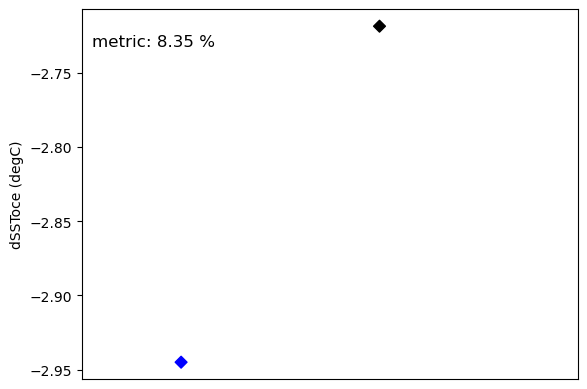

In [91]:
# scatter plot metric

metric_val = abs((ave-ave_obs)/ave_obs)*100

plt.scatter([0,1], [ave,ave_obs], c=['blue','black'], marker='D')

plt.xlim(-0.5,2)#range(-1,3,1)) #['model','obs']
plt.xticks([])

# print(obs_tos_prep["HadISST"].shape, obs_tauu_prep["ERA-Interim"].shape)
# plt.scatter(obs_tos_prep["HadISST"].data, obs_tauu_prep["ERA-Interim"].data,s=20, c='black', marker='D')

plt.ylabel(f'dSSToce (degC)')

## text slope
plt.text(0.02, 0.9, f'metric: {metric_val:.2f} %', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# print(metric_val)

# Diagnostic Level 2
The second level shows the evolution of dSST, dSSTnhf and dSSToce from June to December.

In [35]:
## monthly statistics june to december
## pull out enso years first? -> dsstnhf for dsstoce
from esmvalcore.preprocessor import climate_statistics

def nhf_east(cube_nhf, ds_name): #'ACCESS-ESM1-5'
    model_nhf_prep = {ds_name: east(cube_nhf)}
    cube = model_nhf_prep[ds_name]
    east_cube = extract_season(cube,'JJASOND')
    nhf_east = climate_statistics(east_cube, 'mean', period='month')
    return nhf_east


def month_dsst(cube_prep): #dSST plot black
    a_data = cube_prep.data.data
    a1_data = np.append(np.delete(a_data, 0), 0) #add 0 to end
    trend_data = a1_data - a_data #last month value invalid
    cube_prep.data = trend_data
    cube = extract_season(cube_prep,'JJASOND')[:-1]
    cube = climate_statistics(cube, 'mean', period='month')
    return cube
def month_dSSTnhf(nhf_east, sst_east):
    dtime = 60 * 60 * 24 * 30.42 #s month-1
    Cp = 4000 #J kg-1 degC-1
    rho = 1024 #kg m-3
    H = 50 #m
    dsstnhf = dtime * nhf_east.data / (sst_east.data * Cp * rho * H)
    sst_east.data = dsstnhf
    return sst_east

mod_nhf = nhf_east(model_nhf, 'ACCESS-ESM1-5')
obs_nhf_prep = nhf_east(obs_nhf['ERA-Interim'], 'ERA-Interim') 
#plot
obs_sst_month = month_dsst(obs_ts_prep['TROPFLUX'])
mod_sst_month = month_dsst(model_ts_prep['ACCESS-ESM1-5'])
#plot
model = month_dSSTnhf(mod_nhf, mod_sst_month)
obs = month_dSSTnhf(obs_nhf_prep, obs_sst_month)

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iri

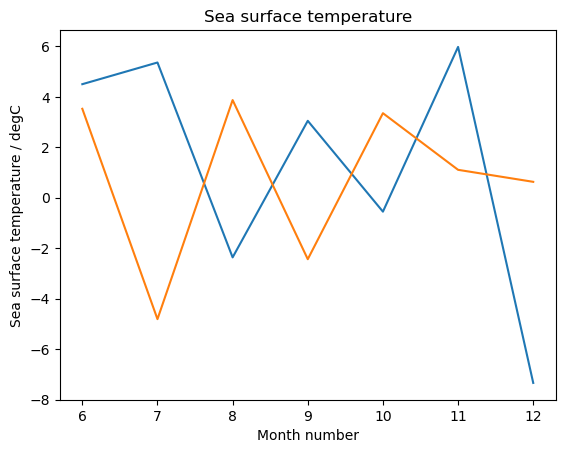

In [37]:
qplt.plot(obs)
qplt.plot(model, label='model')

In [ ]:
events = enso_events(model_ts_enso['ACCESS-ESM1-5'])
print(events)
#run above without monthly statistics
mod_data = dSSTnhf_ninonina(events, model)

events = enso_events(obs_tos_enso['TROPFLUX'])
print(events)
obs_data = dSSTnhf_ninonina(events, obs)